---
```
> Huynh Van Thong
> hvthong.95@gmail.com
> Chonnam National University
> 2018.04
```
---

# Face recognition using Eigenfaces, Fisherfaces

Reference

1. Turk, M. A., & Pentland, A. P. (1991, June). Face recognition using eigenfaces. In Computer Vision and Pattern Recognition, 1991. Proceedings CVPR'91., IEEE Computer Society Conference on (pp. 586-591). IEEE.
2. Belhumeur, P. N., Hespanha, J. P., & Kriegman, D. J. (1997). Eigenfaces vs. fisherfaces: Recognition using class specific linear projection. IEEE Transactions on pattern analysis and machine intelligence, 19(7), 711-720.
3. Gary B. Huang, Vidit Jain, and Erik Learned-Miller. Unsupervised joint alignment of complex images. International Conference on Computer Vision (ICCV), 2007.
4. http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html

[Github link](https://github.com/hvthong/MiniProjectCNU/tree/master/EigenFisherFaces)

# Import library

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import time


# Plot image

In [0]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.savefig("predict.png")
        
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

# **Define class for eigenfaces and fisherfaces**

In [0]:
class EfFace:

    def __init__(self):
        self.egvalues = np.array([])
        self.egvector = np.array([])
        self.mu = 0
        self.mat_transf = np.array([])
        self.x_eg_projected = np.array([])
        self.y_eg_labels = np.array([])

    def pca(self, x_data, n_comp):
        """

        :param x_data: dxn array, n is number of sample, d is number of variable
        :param n_comp: number of components will be kept
        :return:
        """
        # Get mean of variables (by rows)
        x_mean = np.mean(x_data, axis=1).reshape(-1, 1)
        x_adjusted = x_data - x_mean

        # x_adj_cov covariance matrix, size dxd
        x_adj_cov = np.cov(x_adjusted, rowvar=True)

        # Each column is a eigenvector corresponding to a eigenvalue, size dxd
        eg_value, eg_vector = np.linalg.eig(x_adj_cov)

        idx_inc_sort = np.argsort(eg_value)
        idx_dec_sort = np.flip(idx_inc_sort, axis=-1)

        # Matrix for projective, size dxn_comp
        self.mat_transf = eg_vector[:, idx_dec_sort[: n_comp]]
        # print("Size Matrix for pca transform ", self.mat_transf.shape)
        
        self.mu = x_mean

    def eigenface_fit(self, x_data, y_labels, n_comp):
        """

        :param x_data: dxn array, n is number of sample, d is number of variable
        :param n_comp: number of component will be kept
        :return:
        """
        self.pca(x_data, n_comp)
        x_adjusted = x_data - self.mu
        self.x_eg_projected = np.matmul(np.transpose(self.mat_transf), x_adjusted)
        self.y_eg_labels = y_labels

    def fisherface_fit(self, x_data, y_labels):
        """

        Data dimension is much larger then the number of samples d >> n
        :param x_data: dxn array, n is number of sample, d is number of variable
        :param y_labels: labels of samples
        :return:
        """
        lb_unqiue, lb_unique_cnt = np.unique(y_labels, return_counts=True)
        n_classes = np.size(lb_unqiue)
        n_samples = x_data.shape[1]

        # Project with PCA to n_samples - n_classes feature space
        self.pca(x_data, n_samples - n_classes)
        x_adjusted = x_data - self.mu
        
        # Size of x_adjusted_pca: (n_samples - n_classes) x n
        x_adjusted_pca = np.matmul(np.transpose(self.mat_transf), x_adjusted)
        
        # Current dimension (n_samples - n_classes)
        cur_dimen = x_adjusted_pca.shape[0]
        
        
        mu_total = np.mean(x_adjusted_pca, axis=1).reshape(-1, 1)

        # Within-class scatter matrix
        Sw = np.zeros((cur_dimen, cur_dimen))
        # Betweem-class scatter matrix
        Sb = np.zeros((cur_dimen, cur_dimen))

        for c in lb_unqiue:
            c_idx = (y_labels == c)
            cur_samples = x_adjusted_pca[:, c_idx]
            
            if cur_samples.ndim == 1:
              cur_samples = cur_samples.reshape(-1, 1)
              
            # Mean of samples in class c
            mu_c = np.mean(cur_samples, axis=1).reshape(-1, 1)

            Sw = Sw + np.cov(cur_samples, rowvar=True)
            
            mu_c_total = mu_c - mu_total
            Sb = Sb + lb_unique_cnt[c] * np.matmul(mu_c_total, np.transpose(mu_c_total))

        # Calculate eigenvectors, eigenvalues in Equation (2)
        invSw = np.linalg.inv(Sw)
        invSwSb = np.matmul(invSw, Sb)
        
        eg_value, eg_vector = np.linalg.eig(invSwSb)

        idx_inc_sort = np.argsort(eg_value)
        idx_dec_sort = np.flip(idx_inc_sort, axis=-1)

        self.mat_transf = np.matmul(np.transpose(eg_vector[:, : n_classes-1]), 
                                    np.transpose(self.mat_transf)).transpose()
        
        # Calculate transformation matrix
        self.x_eg_projected = np.matmul(self.mat_transf.transpose(), x_adjusted)
        
        self.y_eg_labels = y_labels

    def ef_face_predict(self, x_pred):
        """

        :param x_pred: dxn array, n is number of sample, d is number of variable

        :return: labels for n samples use eigen face or fisher face
        """
        # print(self.x_eg_projected.shape)
        
        # Project query image to eigen/fisher face space
        x_pred_adjusted = x_pred - self.mu
        x_pred_projected = np.matmul(self.mat_transf.transpose(), x_pred_adjusted)
        
        idx = np.arange(x_pred.shape[1])
        y_pred = np.zeros((x_pred.shape[1]), dtype=np.int32) - 1
        
        for ix in idx:
            cur_x = x_pred_projected[:, ix].reshape(-1, 1)
            dis = np.linalg.norm(cur_x - self.x_eg_projected, axis=0)
            y_pred[ix] = self.y_eg_labels[np.argmin(dis)]
        # print("y_pred min ", np.min(y_pred))
        return y_pred

# Get [LFW](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) dataset use class fetch_lfw_people from sklearn.dataset


In [4]:
lfw_people = fetch_lfw_people(resize=0.5, min_faces_per_person=70)

n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names

# Normalize data to [0, 1]
X = X / 255.0
print("Image size: ", h, w)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Image size:  62 47


# Split data to train and test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

print("Number of samples in training and testing set: ", X_train.shape[1], X_test.shape[1])
print("Number of labels: ", len(np.unique(y)))

Number of samples in training and testing set:  966 322
Number of labels:  7


# Create instance of EgienFisherFace

In [0]:
face_rec = EfFace()

# Run eigenfaces

Time fiting eigen face:  42.63222932815552
Accuracy score:  0.45962732919254656
                   precision    recall  f1-score   support

     Ariel Sharon     0.1429    0.2105    0.1702        19
     Colin Powell     0.4375    0.5091    0.4706        55
  Donald Rumsfeld     0.2500    0.2800    0.2642        25
    George W Bush     0.6618    0.6338    0.6475       142
Gerhard Schroeder     0.2941    0.1613    0.2083        31
      Hugo Chavez     0.3125    0.3125    0.3125        16
       Tony Blair     0.2727    0.2647    0.2687        34

      avg / total     0.4670    0.4596    0.4604       322



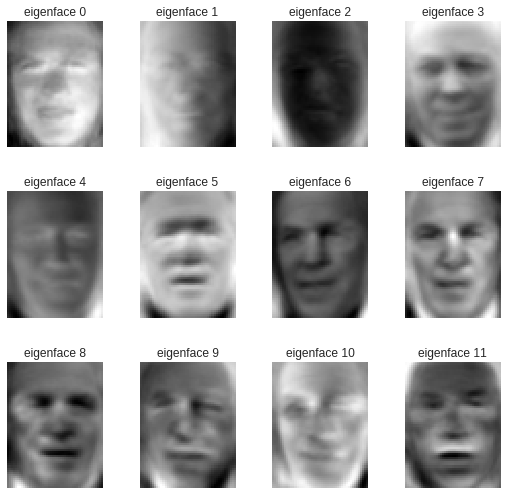

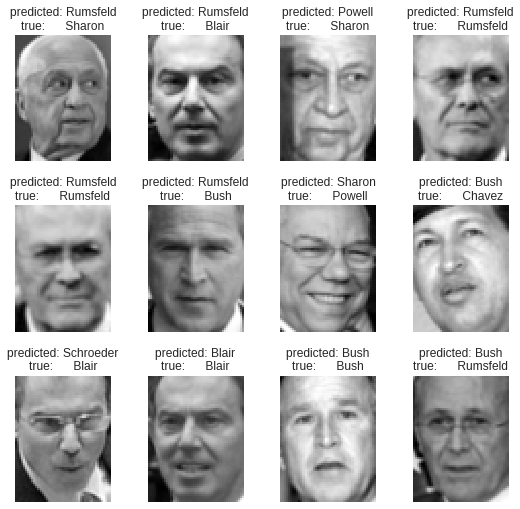

In [7]:
st = time.time()

# Number of component will be kept
n_component = 15

# Fit for training set
face_rec.eigenface_fit(X_train, y_train, n_comp=n_component)

print("Time fiting eigen face: ", time.time() - st)

eigenfaces = np.real(np.reshape(np.transpose(face_rec.mat_transf), 
                                     (n_component, h, w)))

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

# Predict labels for test set
y_pred = face_rec.ef_face_predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=target_names, digits=4))
  
# Plot some example of predict result
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

X_test_plot = np.uint8(255.0*np.transpose(X_test))
plot_gallery(X_test_plot, prediction_titles, h, w)

# Run fisherfaces

Time fit fisher face:  51.181575536727905
Accuracy score:  0.6645962732919255
                   precision    recall  f1-score   support

     Ariel Sharon     0.6667    0.4211    0.5161        19
     Colin Powell     0.6400    0.5818    0.6095        55
  Donald Rumsfeld     0.5000    0.3600    0.4186        25
    George W Bush     0.7394    0.8592    0.7948       142
Gerhard Schroeder     0.6000    0.5806    0.5902        31
      Hugo Chavez     0.5200    0.8125    0.6341        16
       Tony Blair     0.5455    0.3529    0.4286        34

      avg / total     0.6547    0.6646    0.6511       322



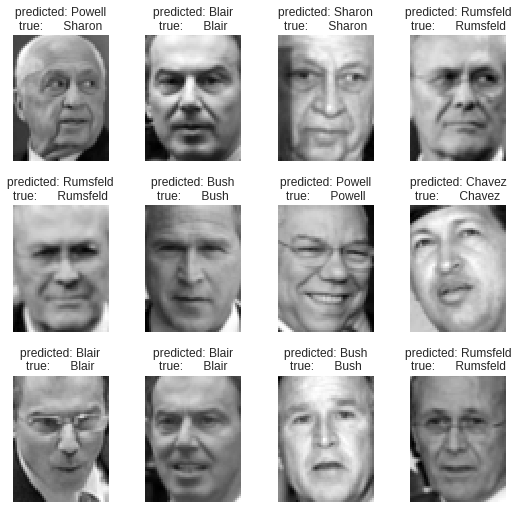

In [8]:
st = time.time()

# Fit fisherfaces in training set
face_rec.fisherface_fit(X_train, y_train)

print("Time fit fisher face: ", time.time() - st)

# User fisherfaces to predict labels for testing set
y_pred = face_rec.ef_face_predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=target_names, digits=4))
  
# Plot some example of predict result
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

X_test_plot = np.uint8(255.0*np.transpose(X_test))
plot_gallery(X_test_plot, prediction_titles, h, w)